# Show counts and percentages for bar plots

In [1]:
import pandas as pd
from plotnine import *
from plotnine.data import mtcars

%matplotlib inline

We can plot a bar graph and easily show the counts for each bar

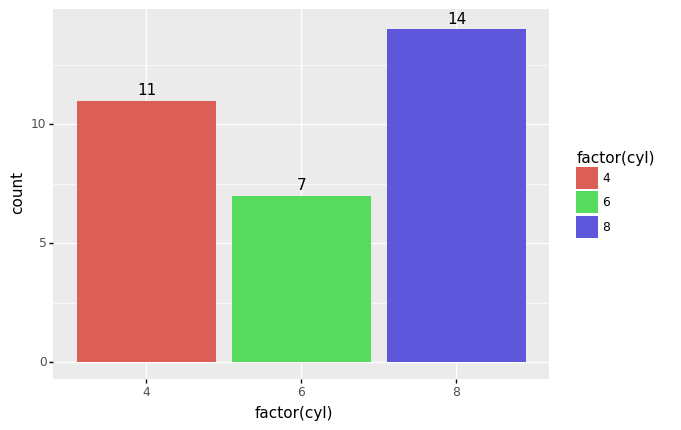

<ggplot: (97654321012345679)>

In [2]:
(ggplot(mtcars, aes('factor(cyl)', fill='factor(cyl)'))
 + geom_bar()
 + geom_text(
     aes(label=after_stat('count')),
     stat='count',
     nudge_y=0.125,
     va='bottom'
 )
)

`stat_count` also calculates proportions (as `prop`) and a proportion can be converted to a percentage.

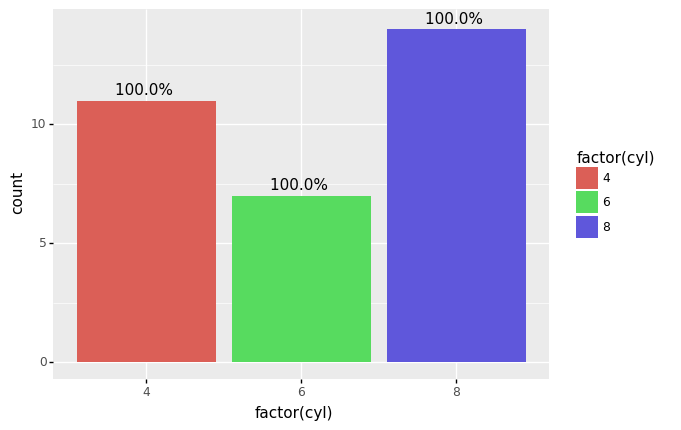

<ggplot: (97654321012345679)>

In [3]:
(ggplot(mtcars, aes('factor(cyl)', fill='factor(cyl)'))
 + geom_bar()
 + geom_text(
     aes(label=after_stat('prop*100')),
     stat='count',
     nudge_y=0.125,
     va='bottom',
     format_string='{:.1f}% '
 )
)

These are clearly wrong percentages. The system puts each bar in a separate group.
We need to tell it to put all bar in the panel in single group, so that the percentage
are what we expect.

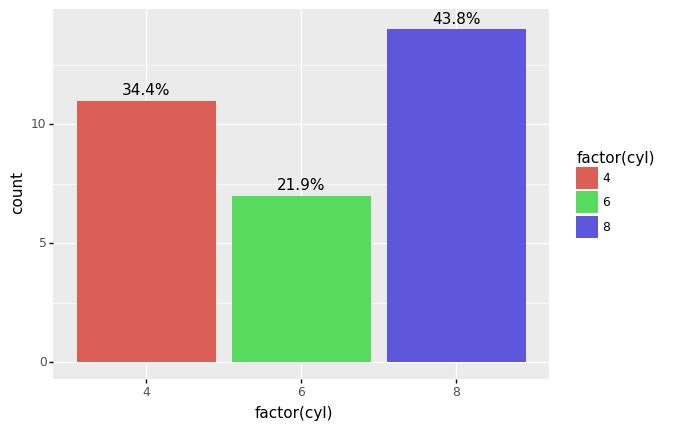

<ggplot: (97654321012345679)>

In [4]:
(ggplot(mtcars, aes('factor(cyl)', fill='factor(cyl)'))
 + geom_bar()
 + geom_text(
     aes(label=after_stat('prop*100'), group=1),
     stat='count',
     nudge_y=0.125,
     va='bottom',
     format_string='{:.1f}%'
 )
)

For more on why automatic grouping may work the way you want, see this [tutorial](./miscellaneous-automatic-grouping-insufficient.ipynb).

We can get the `counts` and we can get the `percentages` we need to print both. We can do that in two ways,

1. Using two `geom_text` layers.

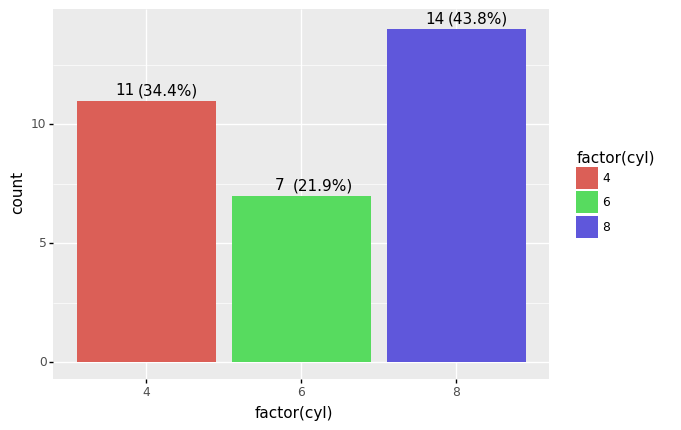

<ggplot: (97654321012345679)>

In [5]:
(ggplot(mtcars, aes('factor(cyl)', fill='factor(cyl)'))
 + geom_bar()
 + geom_text(
     aes(label=after_stat('count')),
     stat='count',
     nudge_x=-0.14,
     nudge_y=0.125,
     va='bottom'
 )
 + geom_text(
     aes(label=after_stat('prop*100'), group=1),
     stat='count',
     nudge_x=0.14,
     nudge_y=0.125,
     va='bottom',
     format_string='({:.1f}%)'
 )
)

2. Using a function to combine the counts and percentages

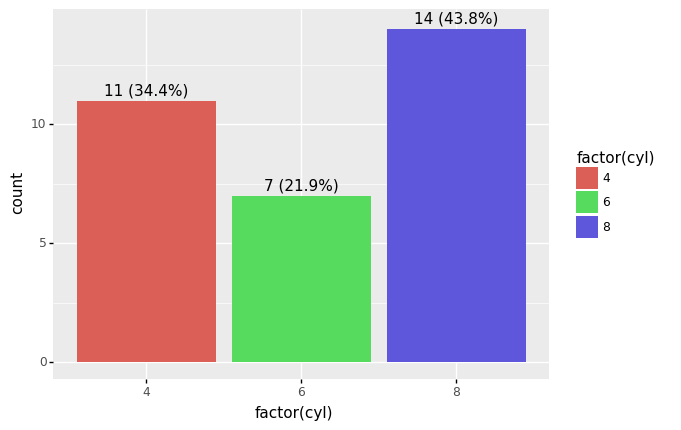

<ggplot: (97654321012345679)>

In [6]:
def combine(counts, percentages):
    fmt = '{} ({:.1f}%)'.format
    return [fmt(c, p) for c, p in zip(counts, percentages)]


(ggplot(mtcars, aes('factor(cyl)', fill='factor(cyl)'))
 + geom_bar()
 + geom_text(
     aes(label=after_stat('combine(count, prop*100)'), group=1),
     stat='count',
     nudge_y=0.125,
     va='bottom'
 )
)

It works with facetting.

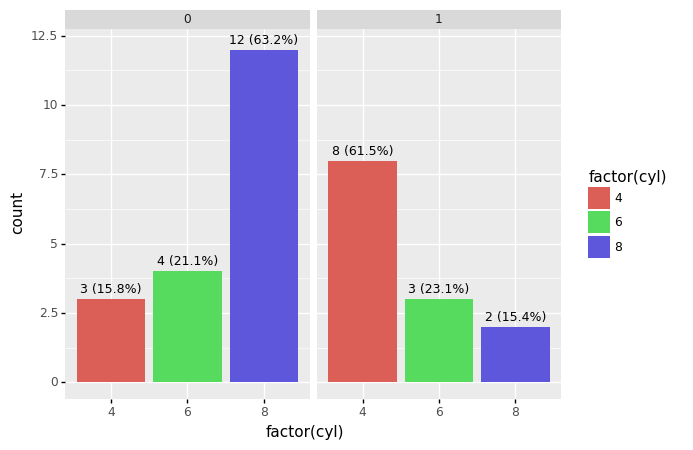

<ggplot: (97654321012345679)>

In [7]:
(ggplot(mtcars, aes('factor(cyl)', fill='factor(cyl)'))
 + geom_bar()
 + geom_text(
     aes(label=after_stat('combine(count, prop*100)'), group=1),
     stat='count',
     nudge_y=0.125,
     va='bottom',
     size=9
 )
 + facet_wrap('am')
)

**Credit:** This example was motivated by the github user [Fandekasp](https://github.com/Fandekasp) (Adrien Lemaire) and difficulty he faced in displaying percentages of bar plots.